<a href="https://colab.research.google.com/github/ismailazdad/uwmgit/blob/main/cocoformat_dataset_creation_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook helps to create a dataset in the cocoformat and also has a visualization with with both coco and detectron API

Reference:
https://www.kaggle.com/code/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/UW_Madison_segmentation/train.zip -d /content/uw-madison-gi-tract-image-segmentation/

In [39]:
!unzip /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip -d /content/uw-madison-gi-tract-image-segmentation/

Archive:  /content/drive/MyDrive/UW_Madison_segmentation/train.csv.zip
  inflating: /content/uw-madison-gi-tract-image-segmentation/train.csv  


In [40]:
!mkdir working

mkdir: cannot create directory ‘working’: File exists


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install pycocotools
! pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [41]:
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [42]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def create_coco_format_json(data_frame, classes, filepaths):
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Additing categories
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )

    for filepath in tqdm(filepaths):
        file_id = ('_'.join((filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        # file_name = '/'.join(filepath.split("/")[2:])
        file_name = '/'.join(filepath.split("/")[3:])
        # print('/'.join(filepath.split("/")[2:]))
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id":file_id,
                    "width":width_slice,
                    "height":height_slice,
                    "file_name": file_name
                }
            )
            for idx in ids:
                mk = rle_decode(data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)              
                contours,hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                for id_, contour in enumerate(contours):
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc =binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation':enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':file_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['class']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1
            
    # creating the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

In [119]:
# creating a dataframe
csv_path = os.path.abspath("/content/uw-madison-gi-tract-image-segmentation/train.csv")
df = pd.read_csv(csv_path)

df_with_mask = df[df['segmentation'].notnull()] # Removing the slices which donot have any segmnatation
df_with_mask = df_with_mask.reset_index(drop=True)

In [120]:
df.shape

(115488, 3)

In [121]:
df[df['segmentation'].isnull()].shape

(81575, 3)

In [124]:
df[df['segmentation'].notnull()].shape

(33913, 3)

In [105]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
dtypes: object(3)
memory usage: 795.0+ KB


In [106]:
df_with_mask['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

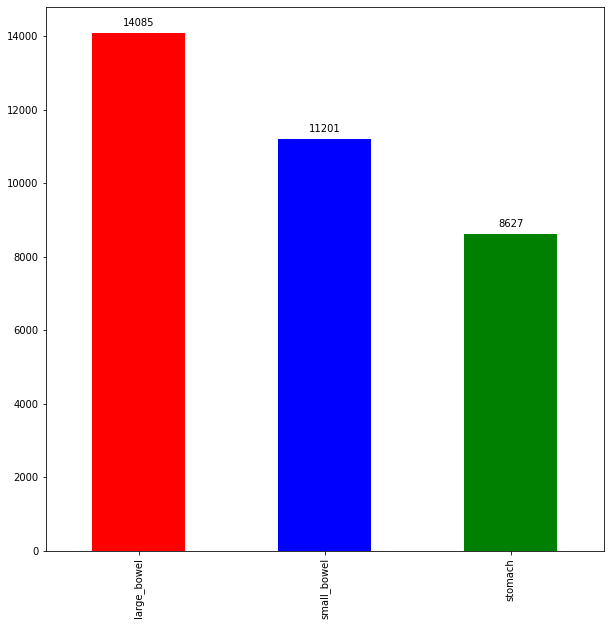

In [117]:
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['class'].value_counts().plot(kind='bar', color=['r','b','g']) 

for p in ax.patches:
    ax.annotate(s=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()

In [43]:
# Setting the paths
dataset_path = os.path.abspath("/content/uw-madison-gi-tract-image-segmentation/")
output_path = os.path.abspath("/content/working/")


# dataset_path = os.path.abspath("/kaggle/input/uw-madison-gi-tract-image-segmentation/")
# output_path = os.path.abspath("/kaggle/working/")
# csv_path = os.path.abspath("/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv")



# Creation of train test split
train_df, test_df = train_test_split(df_with_mask, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))

                        id        class  \
0    case2_day5_slice_0095  small_bowel   
1   case43_day0_slice_0119  large_bowel   
2  case63_day26_slice_0087  large_bowel   
3  case41_day25_slice_0095  large_bowel   
4   case19_day0_slice_0078  small_bowel   

                                        segmentation  
0  20070 3 20334 6 20600 7 20865 9 21131 10 21396...  
1  25961 4 26156 8 26226 9 26420 12 26491 13 2668...  
2  16080 6 16344 9 16610 10 16876 10 17143 10 174...  
3  23850 6 24115 9 24380 13 24646 17 24911 21 251...  
4  30788 17 31146 29 31505 31 31864 34 32223 36 3...  

 
Number of Train Images:27130
Number of Test Images:6783


In [19]:
df['class'].unique()

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

In [20]:
df[df['segmentation'].notnull()].sample(10)

id        class  \
70287   case143_day23_slice_0054  large_bowel   
25567    case65_day25_slice_0091  small_bowel   
88791   case121_day16_slice_0110  large_bowel   
2877     case133_day0_slice_0096  large_bowel   
110673     case2_day1_slice_0124  large_bowel   
88248    case121_day0_slice_0073  large_bowel   
97549    case54_day32_slice_0069  small_bowel   
80238   case131_day19_slice_0091  large_bowel   
15008    case42_day19_slice_0107      stomach   
53318     case7_day19_slice_0093      stomach   

                                             segmentation  
70287   36085 4 36346 10 36611 12 36876 14 37142 14 37...  
25567   19060 3 19323 9 19587 15 19852 17 20117 19 203...  
88791   17155 9 17417 14 17680 18 17943 22 18206 25 18...  
2877    33629 1 33987 17 34345 22 34703 25 35062 26 35...  
110673  23758 10 24022 14 24286 17 24551 20 24817 21 2...  
88248   17970 5 18233 10 18498 12 18764 13 19029 15 19...  
97549   23596 1 23860 6 24125 8 24391 8 24656 10 24922...  
80238   43037 7 43394 14 43752 18 44106 26 44465 28 44...  
15008   21923 7 22186 12 22452 14 22717 15 22984 15 23...  
53318   24339 6 24601 11 24863 16 25126 20 25390 22 25...

In [55]:
classes = ['small_bowel', 'large_bowel', 'stomach']

filepaths = list()
for (dirpath, dirnames, filenames) in os.walk(dataset_path):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".png")]
    
train_json = create_coco_format_json(train_df, classes, filepaths)
test_json = create_coco_format_json(test_df, classes, filepaths)

100%|██████████| 38496/38496 [02:03<00:00, 311.57it/s]


In [56]:
test_json

{'annotations': [{'area': 2095,
   'bbox': [156, 61, 33, 79],
   'category_id': 2,
   'id': 0,
   'image_id': 'case84_day23_slice_0072',
   'iscrowd': 0,
   'segmentation': {'counts': [41616,
     9,
     216,
     8,
     10,
     37,
     205,
     63,
     200,
     67,
     196,
     71,
     193,
     74,
     191,
     75,
     190,
     77,
     189,
     77,
     188,
     78,
     188,
     78,
     187,
     79,
     187,
     79,
     187,
     79,
     187,
     79,
     187,
     78,
     188,
     78,
     188,
     77,
     190,
     75,
     191,
     73,
     193,
     71,
     196,
     68,
     199,
     65,
     202,
     64,
     203,
     62,
     206,
     59,
     209,
     56,
     212,
     53,
     215,
     50,
     218,
     46,
     224,
     39,
     231,
     33,
     244,
     18,
     20635],
    'size': [266, 266]}},
  {'area': 1480,
   'bbox': [118, 29, 44, 47],
   'category_id': 2,
   'id': 1,
   'image_id': 'case84_day23_slice_0072',
   'iscrowd': 

In [60]:
cd working/

/content/working


# Saving the train and test json

In [61]:
# Code taken from: https://stackoverflow.com/a/65151218/12890869
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()
    
with open('train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)
    
with open('test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [126]:
!cp /content/working/test_json.json /content/drive/MyDrive//UW_Madison_segmentation/test_json.json

In [127]:
!cp /content/working/train_json.json /content/drive/MyDrive//UW_Madison_segmentation/train_json.json

In [63]:
cd ..

/content


# Visualization with Detectron2

In [64]:
from pathlib import Path
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

Data_Resister_training="train";
Data_Resister_testing="test";

if Data_Resister_training in DatasetCatalog.list():
    DatasetCatalog.remove(Data_Resister_training)
if Data_Resister_testing in DatasetCatalog.list():
    DatasetCatalog.remove(Data_Resister_testing)

register_coco_instances(
    Data_Resister_training,
    {}, 
    os.path.join(output_path, "train_json.json"), 
    dataset_path)

register_coco_instances(
    Data_Resister_testing,
    {}, 
    os.path.join(output_path, "test_json.json"), 
    dataset_path)

metadata = MetadataCatalog.get(Data_Resister_training)
metadata = MetadataCatalog.get(Data_Resister_testing)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_test = DatasetCatalog.get(Data_Resister_testing)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [67]:
dataset_test

[{'annotations': [{'bbox': [178, 117, 27, 31],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 2,
    'iscrowd': 0,
    'segmentation': {'counts': b'a[^16R84M3N2M4M3L2O1N2O1N100O2O01O000O2O1O0O2N2N2N1O2M3M4LUg?',
     'size': [266, 266]}}],
  'file_name': '/content/uw-madison-gi-tract-image-segmentation/case101/case101_day20/scans/slice_0067_266_266_1.50_1.50.png',
  'height': 266,
  'image_id': 'case101_day20_slice_0067',
  'width': 266},
 {'annotations': [{'bbox': [173, 112, 39, 39],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 2,
    'iscrowd': 0,
    'segmentation': {'counts': b'mQ]12V84M3M2O1O1N4M5K3L4M1N2N2N2N1O2O000000000000000001N101O0O2N1O2N2N2N2M3N2N3L3MRm=',
     'size': [266, 266]}}],
  'file_name': '/content/uw-madison-gi-tract-image-segmentation/case101/case101_day20/scans/slice_0069_266_266_1.50_1.50.png',
  'height': 266,
  'image_id': 'case101_day20_slice_0069',
  'width': 266},
 {'annotations': [{'bbox': [168, 97, 51, 54],
    'bbox_mode': <Bo

/content/uw-madison-gi-tract-image-segmentation/case29/case29_day14/scans/slice_0084_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case89/case89_day0/scans/slice_0101_360_310_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case67/case67_day0/scans/slice_0061_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case144/case144_day0/scans/slice_0059_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case7/case7_day19/scans/slice_0095_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case15/case15_day20/scans/slice_0067_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case129/case129_day24/scans/slice_0095_360_310_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case138/case138_day12/scans/slice_0078_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-segmentation/case33/case33_day0/scans/slice_0114_266_266_1.50_1.50.png
/content/uw-madison-gi-tract-image-se

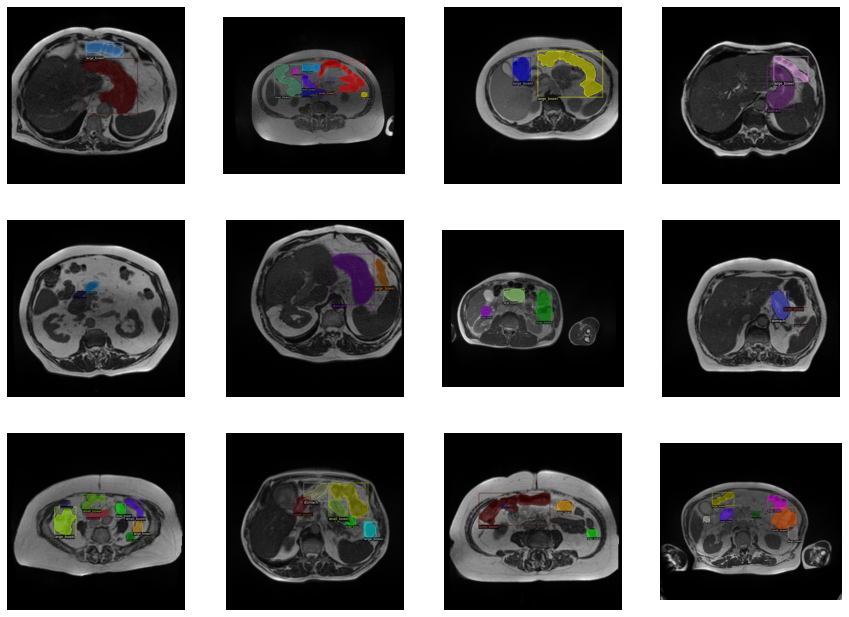

In [125]:
plt.figure(figsize=(15,15))
for i, idx in enumerate(random.sample(range(0, len(dataset_train)), 12)):
    d=dataset_train[idx]
    print(d["file_name"])
    gray_image = cv2.imread(d["file_name"], cv2.IMREAD_ANYDEPTH)
    gray_image = gray_image / gray_image.max()
    img = np.repeat(gray_image[..., np.newaxis], 3, -1) * 255.0
    v = Visualizer(img,
                    metadata=metadata, 
                    scale=2,
                    instance_mode=ColorMode.IMAGE_BW
        )
    out = v.draw_dataset_dict(d)
    plt.subplot(4, 4, i+1)
    plt.imshow(out.get_image())
    plt.axis('off')
plt.show()